# Covid Literature Clustering using the contents of abstracts

### The goal of this Jupyter notebook is to explore two methods of extracting topics from a given dataset, Lda and BERT Topic Modelling.

# Approach:

- Clean and process the abstract of each article, removing stopwords, non-english text and punctuation.
- Parse the text using Natural Language Processing (NLP).
- Apply  Latent Dirichlet Allocation (LDA) topic modelling to discover the the clustering of topics contained within the abstracts.
- Apply BERTopic to the same dataset and compare results to our Lda model as well as discover how the prevalance of the topics changed throughout 2020.
- Use t-Distributed Stochastic Neighbor Embedding (t-SNE) to visualise the topics generated by the LDA model.

## Loading in our Data

In [80]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Reading in our data and turning it into a pandas dataframe

covid_data = pd.read_json('data.json', dtype={'abstract':str})

# Taking a look at our data

covid_data.head()

,_id,indexed,reference-count,publisher,issue,content-domain,short-container-title,abstract,DOI,type,...,update-to,ISBN,content-created,publisher-location,standards-body,approved,event,isbn-type,chair,translator
0,10.24042/tadris.v5i1.6283,"{'date-parts': [[2020, 7, 3]], 'date-time': '2...",0,Raden Intan State Islamic University of Lampung,1,"{'domain': [], 'crossmark-restriction': False}",[Tadris],<jats:p>COVID-19 harms the implementation of l...,10.24042/tadris.v5i1.6283,journal-article,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10.3390/su12124930,"{'date-parts': [[2020, 6, 17]], 'date-time': '...",53,MDPI AG,12,"{'domain': [], 'crossmark-restriction': False}",[Sustainability],"<jats:p>Due to the COVID-19 pandemic, the Worl...",10.3390/su12124930,journal-article,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10.21203/rs.3.rs-27288/v1,"{'date-parts': [[2020, 5, 11]], 'date-time': '...",0,Research Square,NaN,"{'domain': [], 'crossmark-restriction': False}",[],<jats:title>Abstract</jats:title>\n <ja...,10.21203/rs.3.rs-27288/v1,posted-content,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10.1302/2046-3758.16.bjo-2020-0035.r1,"{'date-parts': [[2020, 6, 3]], 'date-time': '2...",10,British Editorial Society of Bone & Joint Surgery,6,"{'domain': [], 'crossmark-restriction': False}",[Bone & Joint Open],<jats:sec><jats:title>Aims</jats:title><jats:p...,10.1302/2046-3758.16.bjo-2020-0035.r1,journal-article,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10.31234/osf.io/h8w9e,"{'date-parts': [[2020, 6, 18]], 'date-time': '...",0,Center for Open Science,NaN,"{'domain': [], 'crossmark-restriction': False}",[],<p>Background and Objectives: The Coronavirus ...,10.31234/osf.io/h8w9e,posted-content,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Since the purpose of our analysis is to extract the main topics within the abstracts, we will be limiting our analyisis to the contents of the abstracts. Note that this same method of analysis may also be applied to the body of the articles or keywords.

In [81]:
# Removing all columns expect the abstract and the created columns for visualization and evualation purposes. 

covid_data = covid_data[['abstract','created']]


## Cleaning and pre-processing the data


In [82]:
import calendar, time

# Lets first remove any rows with missing abstracts
covid_data['abstract'].dropna(inplace=True)

# Clean created column
covid_data['created'] = covid_data['created'].apply(lambda x: x['date-parts'][0])
covid_data['month'] = covid_data['created'].apply(lambda x: x[1])
covid_data['month'] = covid_data['month'].apply(lambda x: calendar.month_name[x])



In [68]:

list(covid_data['month'])

['July',
 'June',
 'May',
 'June',
 'June',
 'May',
 'April',
 'June',
 'May',
 'April',
 'July',
 'April',
 'April',
 'May',
 'May',
 'April',
 'May',
 'April',
 'July',
 'April',
 'March',
 'March',
 'May',
 'April',
 'March',
 'May',
 'June',
 'July',
 'June',
 'June',
 'May',
 'May',
 'May',
 'July',
 'March',
 'April',
 'June',
 'June',
 'May',
 'June',
 'March',
 'March',
 'March',
 'March',
 'June',
 'June',
 'May',
 'March',
 'March',
 'June',
 'June',
 'February',
 'February',
 'April',
 'July',
 'May',
 'May',
 'May',
 'February',
 'April',
 'June',
 'June',
 'July',
 'June',
 'May',
 'June',
 'April',
 'June',
 'July',
 'May',
 'June',
 'June',
 'April',
 'May',
 'May',
 'May',
 'May',
 'June',
 'May',
 'April',
 'May',
 'March',
 'June',
 'June',
 'May',
 'June',
 'June',
 'April',
 'April',
 'May',
 'June',
 'May',
 'June',
 'June',
 'May',
 'April',
 'May',
 'May',
 'May',
 'April',
 'April',
 'May',
 'May',
 'March',
 'March',
 'February',
 'June',
 'June',
 'June',
 'Ju

## Removing non-english articles
Slightly modifieing the language detection method used [here](https://www.kaggle.com/jswxhd/risk-factor-mining-cord-19-articles-2021), we are able to remove all non english articles from our dataframe.

In [44]:
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory

# set seed
DetectorFactory.seed = 0

# hold label - language
languages = []

# go through each text
for ii in tqdm(range(0,len(covid_data))):
    # split by space into list, take the first x intex, join with space
    text = covid_data.iloc[ii]['abstract'].split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    
    except:
        lang = 'unknown'
    
    # get the language    
    languages.append(lang)
    

100%|██████████| 47086/47086 [01:35<00:00, 490.70it/s]


Cite: [COVID-19 Literature Clustering](https://www.kaggle.com/maksimeren/covid-19-literature-clustering)

In [87]:
# Keep month and abstract colunn
covid_data = covid_data[['abstract', 'month']]

# Creating a column of the articles language 
covid_data['language'] = languages

# Keeping only articles in english
covid_data = covid_data[covid_data['language'] == 'en'] 

In [88]:
#% Function to change month name to number

def monthToNum(shortMonth):
   
    return {
            'January': 1,
            'February': 2,
            'March': 3,
            'April': 4,
            'May': 5,
            'June': 6,
            'July': 7,
            'August': 8,
            'September': 9, 
            'October': 10,
            'November': 11,
            'December': 12
    }[shortMonth]

# Applying function to abstract text
covid_data['month'] = covid_data['month'].apply(monthToNum)


## Cleaning the abstract Data

In [89]:
# NLP

import nltk, spacy, string, re

# Parser for processing scientific, biomedical or clinical text
nlp = spacy.load("en_core_sci_lg")

# Stopwords (common words which distort the analysis)
from spacy.lang.en.stop_words import STOP_WORDS
stopwords = list(STOP_WORDS)

# Lets remove some common words which we have missed in the cleaning process and words which have emerged from revewing the results of our
# model.
remove_words = ['covid', 'covid_pandemic', 'use', 'sarcov', 'model', 'level', 'coronaviruse', 
               'population', 'coronavirus', 'literature', 'datum', 'cause', 'risk'
]

# Next, we will use the custom stopwords created by Daniel Wolfram to further refine our data.
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI']
stopwords.extend(remove_words + custom_stop_words)

# Punctuations
punctuations = string.punctuation


In [90]:
#%% Function to clean the abstracts

def clean_abstract(text):
    
    tokens = nlp(text)
    
    tokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens ]
    
    # Remove HTML formatting 
    tokens = [re.sub(r'\<[^()]*\>', '', word) for word in tokens]
    # Remove words less than 3 letters in length
    tokens = [word for word in tokens if len(word) > 3]
    # Remove numbers
    tokens = [word for word in tokens if word.isalpha()]
    # Remove stopwords and punctuations
    tokens = [word for word in tokens if word not in stopwords and word not in punctuations]
    # Remove 'ing'
    tokens = [word[:-3] if word[-3:] == "ing" else word for word in tokens]
    # Keeps nouns
    tokens = [word for (word, pos) in nltk.pos_tag(tokens) if pos[:2] == 'NN']
    # Rejoin tokens
    tokens = " ".join([i for i in tokens])
    
    return tokens

In [91]:
tqdm.pandas()

# Apply processing function to the abstract text
covid_data["processed_text"] = covid_data["abstract"].progress_apply(clean_abstract)


100%|██████████| 16139/16139 [10:03<00:00, 26.72it/s]


In [92]:
# For the Lda model we require that the text be in the form a list of lists of words, we can use the nltk.word_tokenize() function to acheive
# this
text_to_analyse = list(covid_data['processed_text'].apply(lambda x: nltk.word_tokenize(x)))


,abstract,month,language,processed_text
0,<jats:p>COVID-19 harms the implementation of l...,7,en,harm implementation university student univers...
1,"<jats:p>Due to the COVID-19 pandemic, the Worl...",6,en,world health organization authority hand wash ...
2,<jats:title>Abstract</jats:title>\n <ja...,5,en,title title manifestation pneumonia pneumonia ...
3,<jats:sec><jats:title>Aims</jats:title><jats:p...,6,en,fracture patient illness admission hospital im...
4,<p>Background and Objectives: The Coronavirus ...,6,en,background disease people life health study me...


Cite: [Topic Modeling: Finding Related Articles](https://www.kaggle.com/danielwolffram/topic-modeling-finding-related-articles)

## Lets take a look at our data before we build the topic models

### Top words within the abstracts post processing

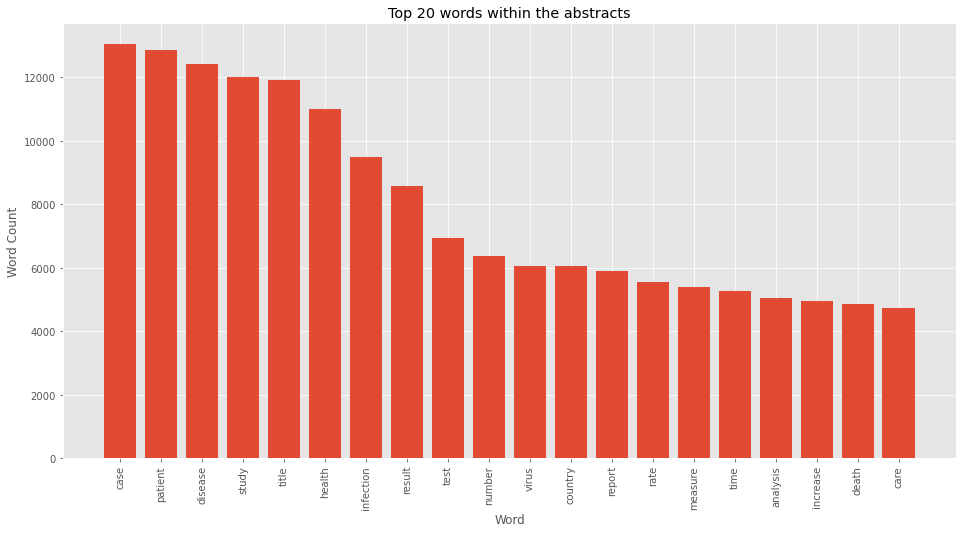

In [18]:
from collections import Counter

n_top_words = 20

# Flattened list of the words
text_flat = [y for x in text_to_analyse for y in x]

# Dictoinary with the words as keys and the frequency the word as values
word_count_dict = Counter(text_flat)
sorted_word_count_dict = dict(sorted(word_count_dict.items(), key=lambda item: item[1], reverse=True))
word_values = list(sorted_word_count_dict.values())[:n_top_words]
words = list(sorted_word_count_dict.keys())[:n_top_words]
# Plot
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title(f"Top {n_top_words} words within the abstracts");
ax.set_xlabel('Word');
ax.set_ylabel('Word Count');
plt.show()


### Wordcloud of top words within abstract

Text(0.5, 1.0, 'Word Cloud: key words within the abstracts')

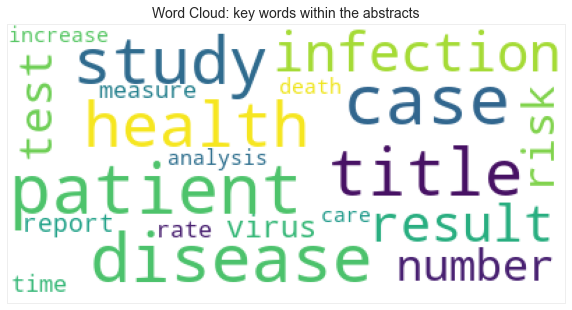

In [202]:
from wordcloud import WordCloud



# Generating the wordcloud
wcloud = WordCloud(max_font_size=50, max_words=n_top_words, background_color="white")
wcloud.generate_from_frequencies(word_count_dict)
fig,ax = plt.subplots(figsize=(10,8))
ax.imshow(wcloud)
for pos in ['left','right','top','bottom']:
    ax.spines[pos].set_color(None)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Word Cloud: key words within the abstracts' ,fontsize=14)

# Lda Model

In [83]:
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
id2token = Dictionary(text_to_analyse)

# Filter extremes
id2token.filter_extremes(no_below=10, no_above=.2)

# Vectorize data
corpus = [id2token.doc2bow(tokens) for tokens in text_to_analyse]

In [84]:
import gensim

# Set parameters.
num_topics = 10
chunksize = 1000 
passes = 50 
iterations = 1000
eval_every = 1 



model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2token, chunksize=chunksize, 
                       eta='auto', 
                       iterations=iterations, num_topics=num_topics, 
                       passes=passes, eval_every=eval_every)


## Visualize the results

### Similarity Matrix

In [223]:
from collections import OrderedDict
import matplotlib.pyplot as plt

# Dataframe of the 10 most important terms with each topic 
df_model = pd.DataFrame({i: OrderedDict(model.show_topic(i,10)) for i in range(num_topics)})
df_model = df_model.fillna(0).T


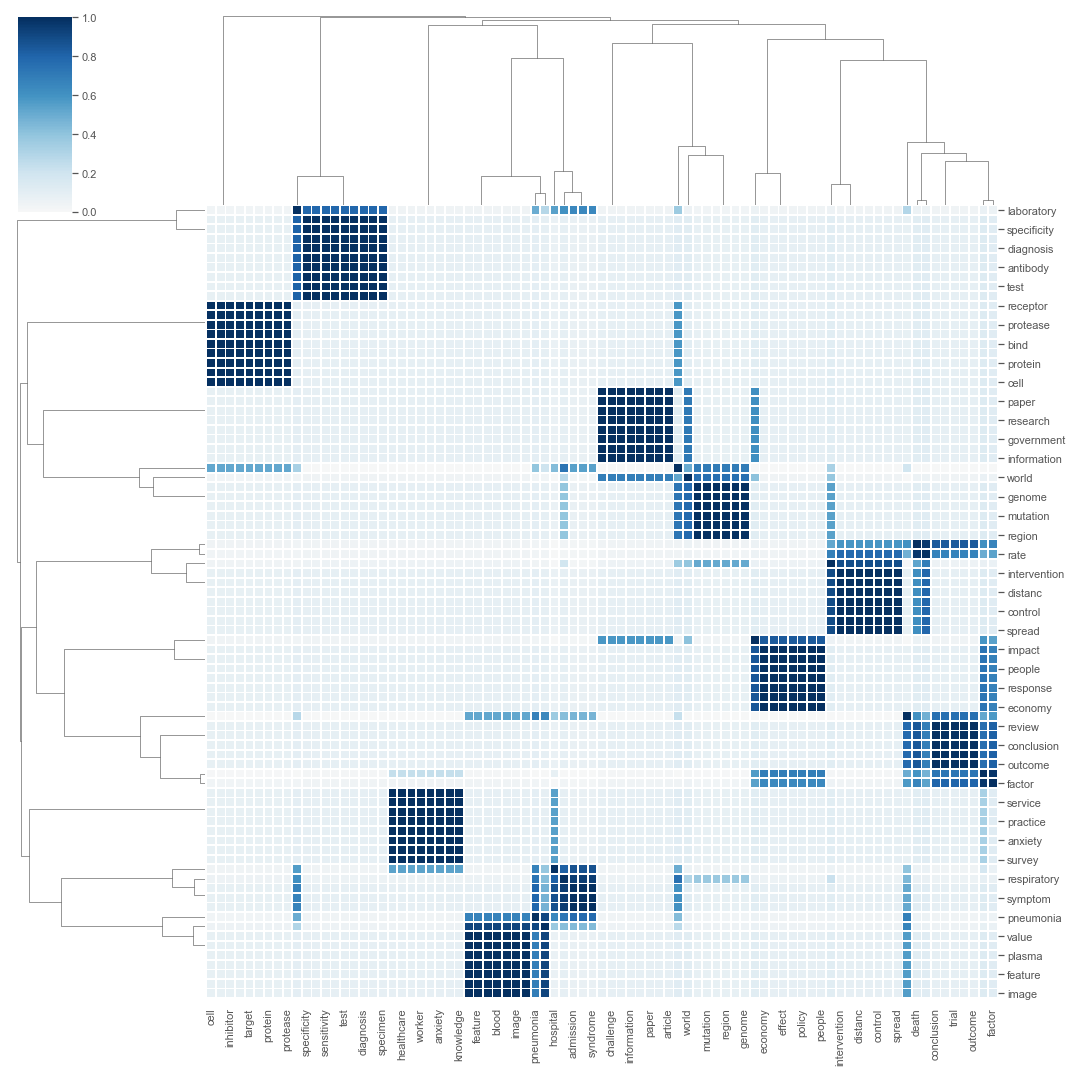

In [224]:

sb.clustermap(df_model.corr(), center=0, standard_scale=1, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(15, 15))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

In [85]:

import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
import warnings 

warnings.filterwarnings("ignore", category=DeprecationWarning) 
vis = pyLDAvis.gensim_models.prepare(model, corpus, id2token)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.094474  0.042402       1        1  16.224799
3     -0.121763 -0.120518       2        1  15.661059
7      0.050261  0.260740       3        1  12.874860
9     -0.169100 -0.162075       4        1   9.778334
2      0.193757 -0.039293       5        1   9.219518
8     -0.151297  0.109463       6        1   9.141595
4      0.247980 -0.127880       7        1   8.333970
6     -0.052522  0.049983       8        1   8.283070
0      0.083939  0.106058       9        1   6.396337
5      0.013219 -0.118881      10        1   4.086457, topic_info=            Term         Freq        Total Category  logprob  loglift
93          test  6796.000000  6796.000000  Default  30.0000  30.0000
685         drug  3749.000000  3749.000000  Default  29.0000  29.0000
90       protein  2777.000000  2777.000000  Default  28.0000  28.0000
286      country  5881.000000  5881.000000  Default  27.0000  27.0000
165         cell  3203.000000  3203.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
360    condition   202.809974  1680.725903  Topic10  -5.0067   1.0828
104      control   205.229651  3888.165785  Topic10  -4.9948   0.2559
93          test   193.333636  6796.812540  Topic10  -5.0545  -0.3623
112     hospital   183.404631  3128.994640  Topic10  -5.1073   0.3607
274  respiratory   179.584707  4353.576107  Topic10  -5.1283   0.0094

[762 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
3750      9  0.990577       abbott
475       3  0.986537  abnormality
475       9  0.012812  abnormality
340       1  0.025137       access
340       2  0.699458       access
...     ...       ...          ...
489       1  0.794165         york
489       2  0.023825         york
489       3  0.162804         york
489       4  0.011912         york
489       6  0.003971         york

[2162 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 8, 10, 3, 9, 5, 7, 1, 6])

## How to interprate this graph
- The degree to which the seperation between topics has been achieved by our model is seen in the seperation of the circles.
- The distance between the circles relates to the distance between topics for instance 9 and 10 appear fairly close when compared to 6 and 8.
- The size of the circle shows the size of the topics in terms of total articles which fall into the topic.

We wish to tune the parameters of the model as well as refine our input corpus so that topic overlap is minimized.

## Wordcloud of the top words within each topic

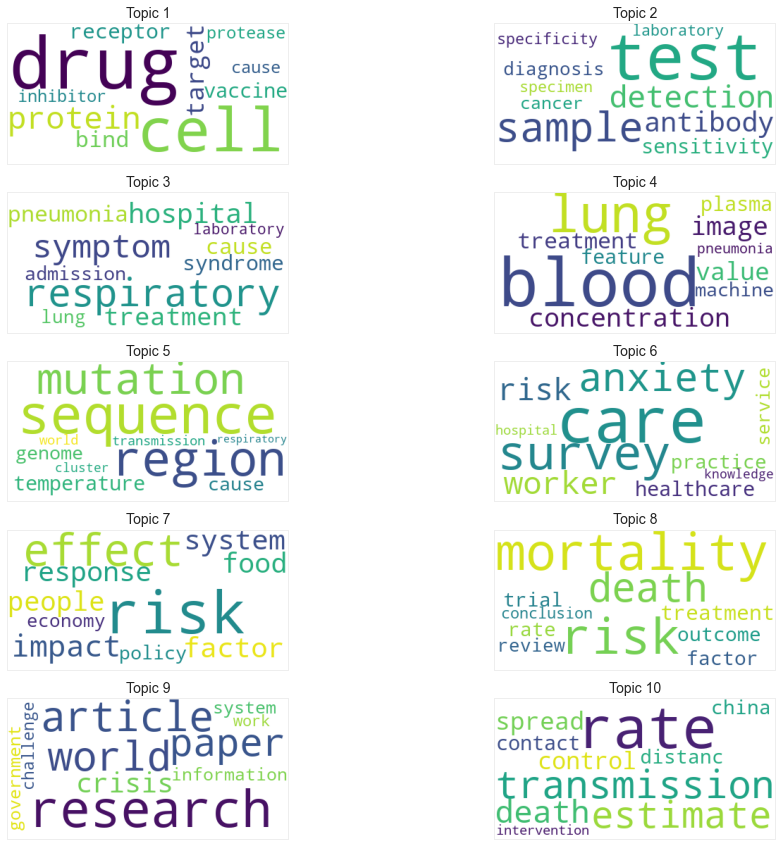

In [227]:
import seaborn as sb

# Generate wordcloud
word_topic_scores = model.show_topics(num_topics = num_topics, num_words=10,formatted=False)
fig = plt.figure(figsize=(16,15))
cols = sb.hls_palette(15, l=.4, s=.9)
for i,topic in enumerate(word_topic_scores):
    word_score_pairs = topic[1]
    
    words = [word_score_pair[0] for word_score_pair in word_score_pairs]
    
    probs = [word_score_pair[1] for word_score_pair in word_score_pairs]
    words_prob_pairs = dict(zip(words, probs))
        
    ax= fig.add_subplot(5,2,i+1)
    
    wcloud = WordCloud(
                       background_color='white',
                     
                      )
    wcloud.generate_from_frequencies(words_prob_pairs)
    ax.imshow(wcloud)
    for pos in ['left','right','top','bottom']:
        ax.spines[pos].set_color(None)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Topic {i+1}' ,fontsize=14, 
                )


## Plotting the weighting of each word within the topic versus its frequency
I would like to thank Selva Prabhakaran for his method to refine the corpus by plotting out the frequencies of the words against its weight within the topics generated by the Lda model. Through the iterative removal of words whose frequency far exceeds its weight and words which appear throughout multiple topics, we were able to refine the model to produce greater seperation of clusters and more meaningful topics. 

Cite: [Topic modeling visualization – How to present the results of LDA models?](https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/)

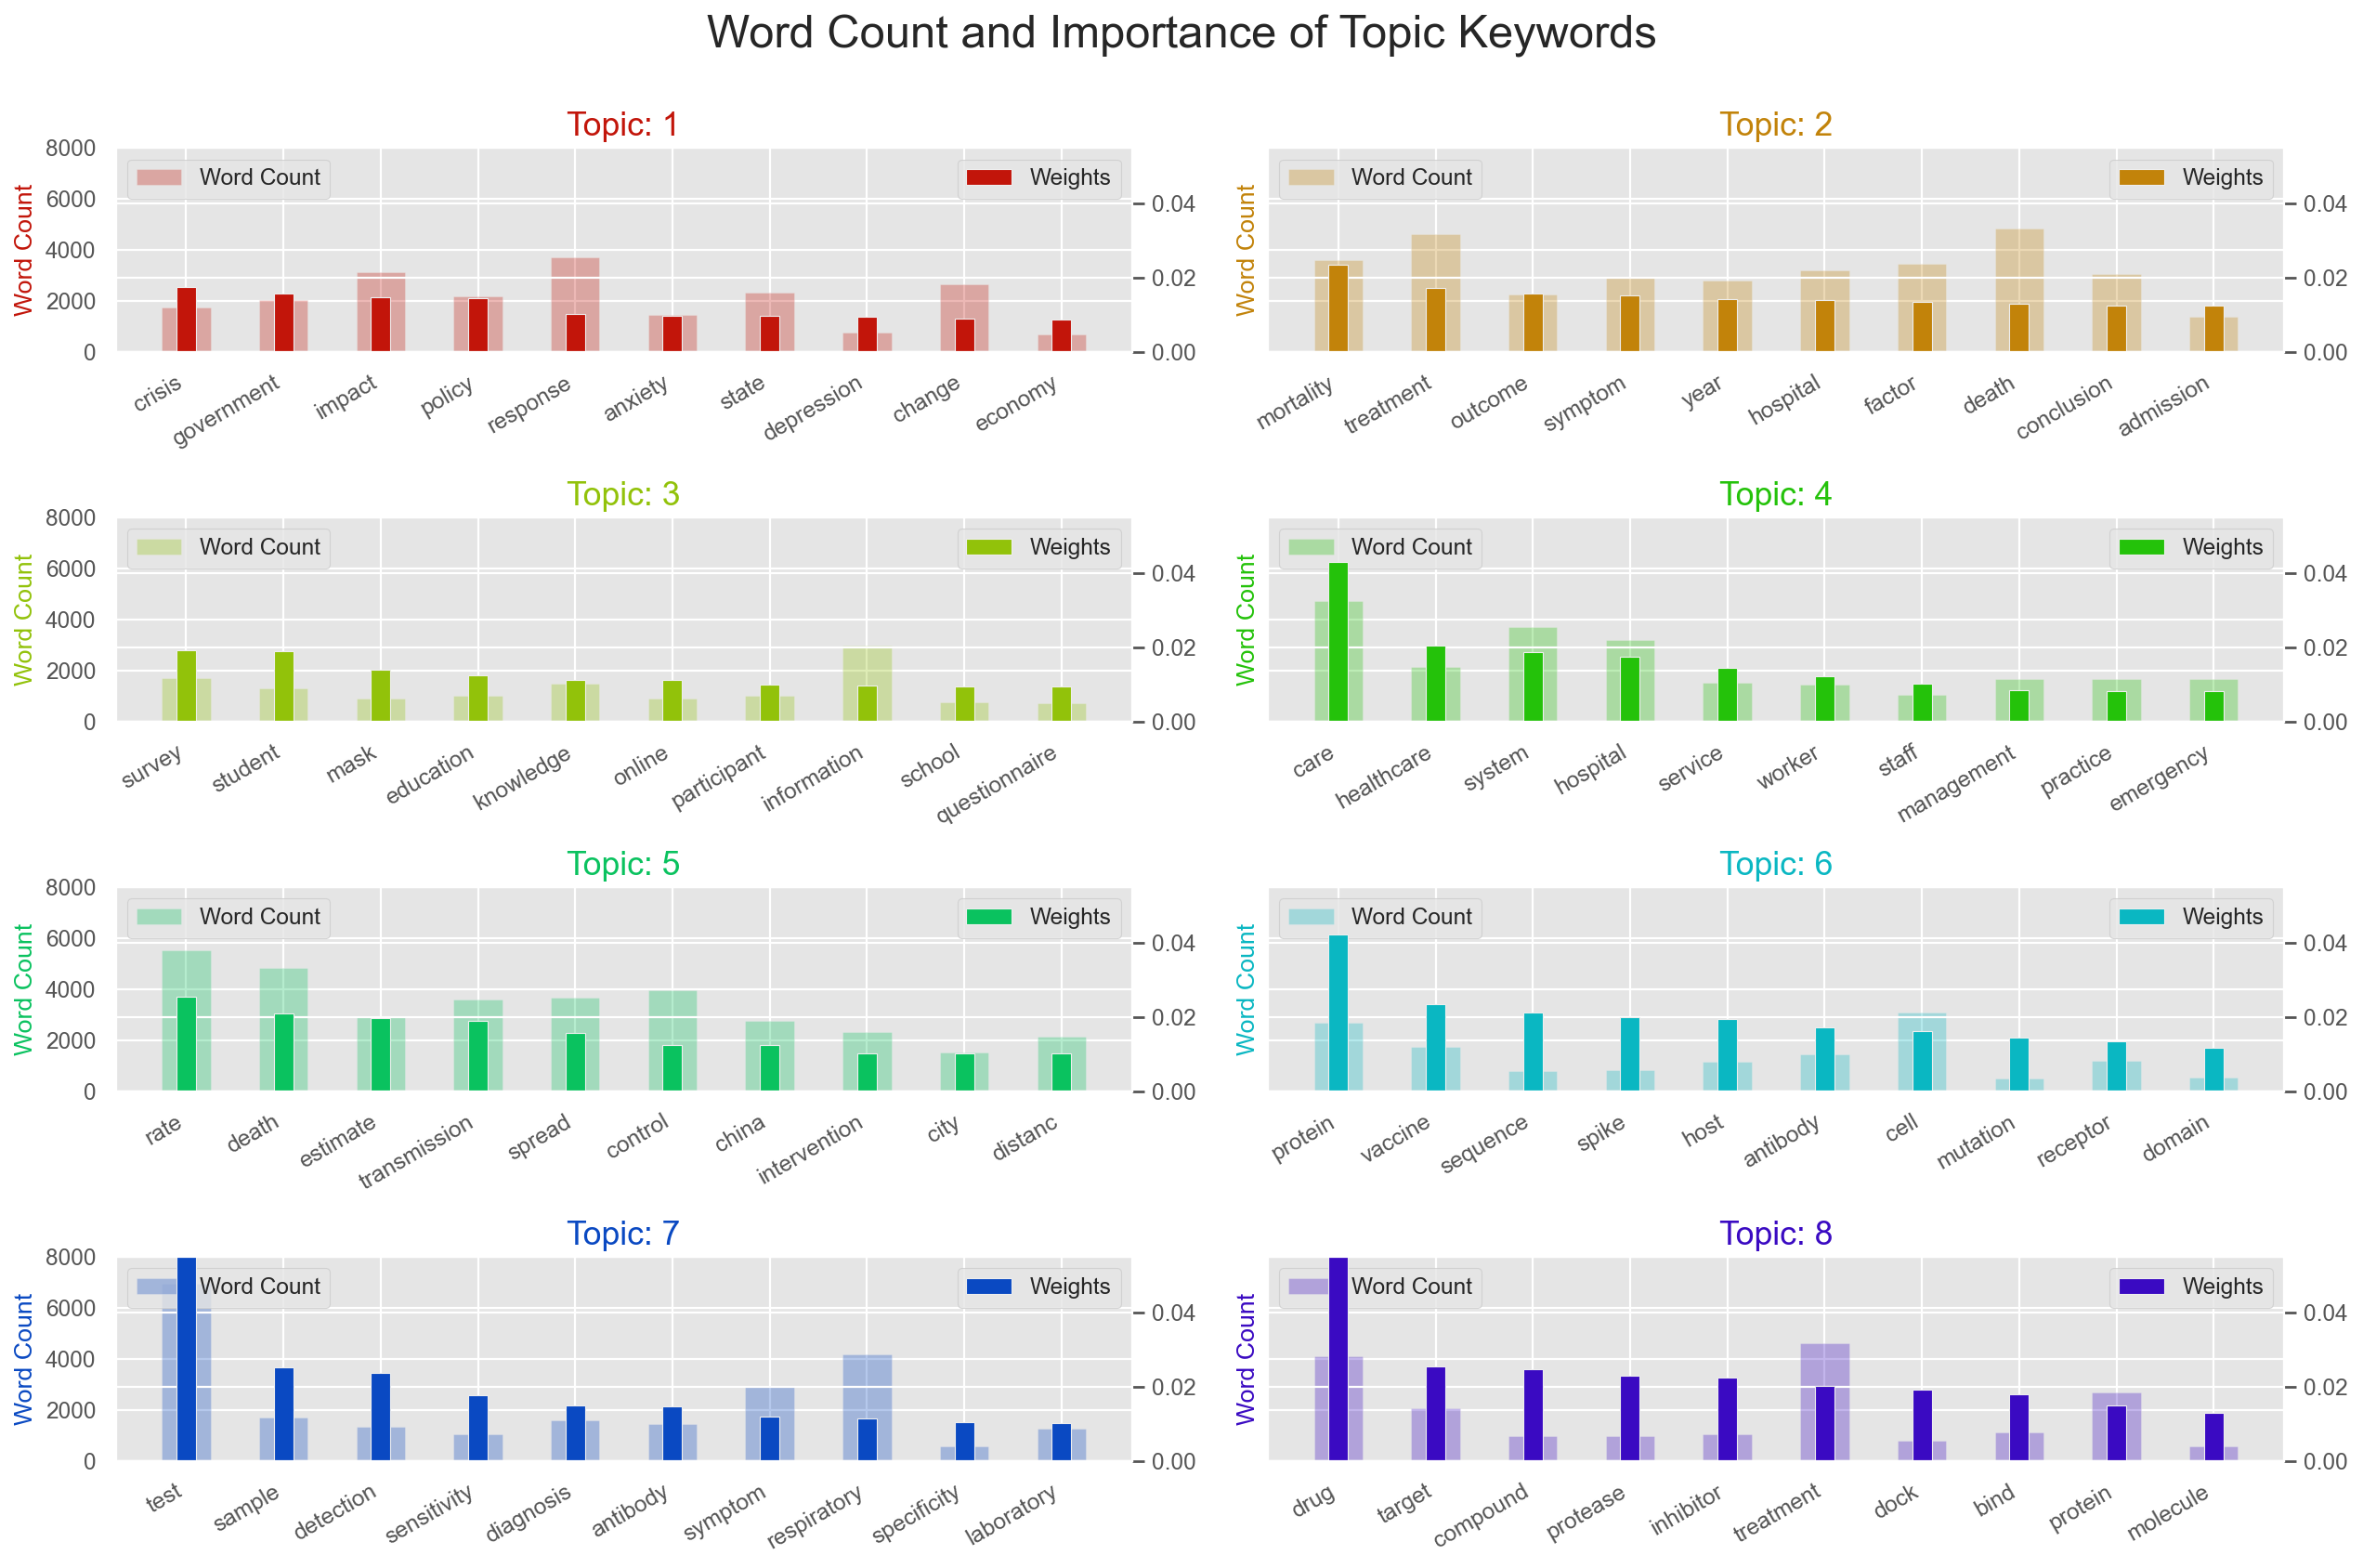

In [244]:
import collections
import seaborn as sb

warnings.filterwarnings("ignore", category=UserWarning) 
topics = model.show_topics(num_topics = 15, formatted=False)
data_flat = [w for w_list in text_to_analyse for w in w_list]
counter = collections.Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        
cols = sb.hls_palette(10, l=.4, s=.9)
# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(4, 2, figsize=(16,10), sharey=True, dpi=160)

for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.055); ax.set_ylim(0, 8000)
    ax.set_title('Topic: ' + str(i + 1), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [248]:
# Matrix of probability that each article falls into a topic.
document_topic_matrix = np.zeros((len(corpus),num_topics))
for idx,document_topic in enumerate(model[corpus]):
    for topic_idx,prob in document_topic:
        document_topic_matrix[idx][topic_idx] = prob

# Taking the maximum of the probablities for each article we obtian the topic that each article belongs to.
topic_number1 = np.argmax(document_topic_matrix, axis=1)

# Adding the topic number to our dataframe for graphing purposes
covid_data['topic_number_lda'] = topic_number1
pd.DataFrame(document_topic_matrix).head()

,0,1,2,3,4,5,6,7,8,9
0,0.000000,0.000000,0.614444,0.109631,0.000000,0.000000,0.000000,0.000000,0.259254,0.000000
1,0.040602,0.000000,0.891394,0.061070,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.672819,0.000000,0.000000,0.000000,0.000000,0.310506,0.000000,0.000000,0.000000
3,0.000000,0.286754,0.000000,0.506154,0.000000,0.000000,0.056269,0.141727,0.000000,0.000000
4,0.311360,0.000000,0.670850,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
16134,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.989019,0.000000,0.000000
16135,0.000000,0.000000,0.036339,0.000000,0.000000,0.036270,0.812719,0.110256,0.000000,0.000000
16136,0.000000,0.000000,0.081187,0.000000,0.000000,0.000000,0.094825,0.000000,0.000000,0.816691
16137,0.000000,0.000000,0.000000,0.000000,0.026201,0.826327,0.000000,0.137019,0.000000,0.000000


## t-SNE Visualizations
Using t-SNE we reduce our high demensional feature vector in this case 10 features to 2 dimension. T-SNE will attempt to preserve the relations betweens the topics which our Lda model has computed in the x,y plane.

In [251]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=50, verbose=1)
X_embedding = tsne.fit_transform(document_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 16139 samples in 0.114s...
[t-SNE] Computed neighbors for 16139 samples in 1.578s...
[t-SNE] Computed conditional probabilities for sample 1000 / 16139
[t-SNE] Computed conditional probabilities for sample 2000 / 16139
[t-SNE] Computed conditional probabilities for sample 3000 / 16139
[t-SNE] Computed conditional probabilities for sample 4000 / 16139
[t-SNE] Computed conditional probabilities for sample 5000 / 16139
[t-SNE] Computed conditional probabilities for sample 6000 / 16139
[t-SNE] Computed conditional probabilities for sample 7000 / 16139
[t-SNE] Computed conditional probabilities for sample 8000 / 16139
[t-SNE] Computed conditional probabilities for sample 9000 / 16139
[t-SNE] Computed conditional probabilities for sample 10000 / 16139
[t-SNE] Computed conditional probabilities for sample 11000 / 16139
[t-SNE] Computed conditional probabilities for sample 12000 / 16139
[t-SNE] Computed conditional probabilities for sa

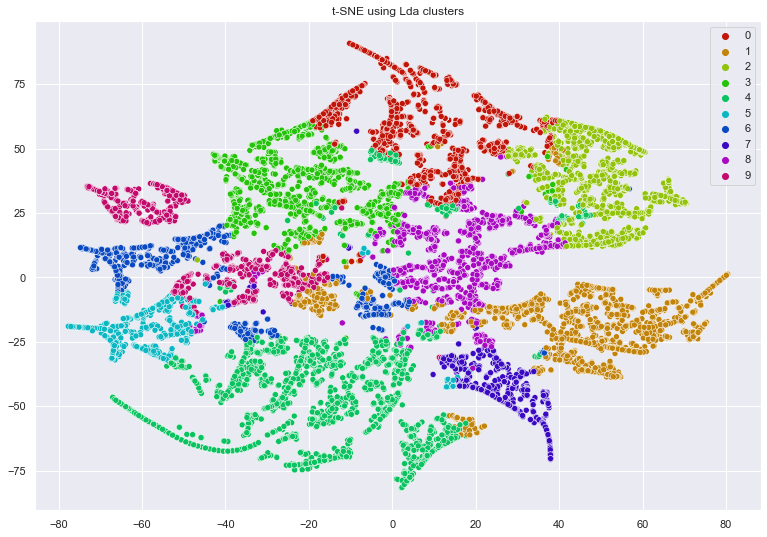

In [253]:


import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

# sb settings
sb.set(rc={'figure.figsize':(13,9)})

# colors
palette = sb.hls_palette(num_topics, l=.4, s=.9)

# plot
sb.scatterplot(X_embedding[:,0], X_embedding[:,1], hue=topic_number1, legend='full', palette=palette)
plt.title('t-SNE using Lda clusters')

plt.show()


## BERTopic
Lets apply BERTopic modeling to the same data and compare the results. 




In [120]:
from bertopic import BERTopic
abstracts = list(covid_data['processed_text'])
topic_model = BERTopic(verbose=True, embedding_model="paraphrase-MiniLM-L12-v2", min_topic_size=50)
topics, _ = topic_model.fit_transform(abstracts); len(topic_model.get_topic_info())

Batches:   0%|          | 0/505 [00:00<?, ?it/s]

2021-11-16 18:54:28,941 - BERTopic - Transformed documents to Embeddings
2021-11-16 18:54:34,797 - BERTopic - Reduced dimensionality with UMAP
2021-11-16 18:54:35,604 - BERTopic - Clustered UMAP embeddings with HDBSCAN


20

In [116]:
# Next, we can reduce the 30 generated topics down to 10 so as too match the number we used for the Lda model

reduced_topics, _ = topic_model.reduce_topics(abstracts, topics, nr_topics=10)

2021-11-16 18:40:23,452 - BERTopic - Reduced number of topics from 29 to 11


# Lets have a look at the 10 largest topics generated and see if they allign with those we obtained from the Lda model

In [117]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,8694,-1_patient_disease_health_study
1,0,2259,0_death_rate_spread_disease
2,1,1012,1_crisis_government_economy_policy
3,2,888,2_protein_virus_receptor_gene
4,3,669,3_mask_antibody_respirator_swab
5,4,606,4_anxiety_depression_stress_symptom
6,5,603,5_patient_lung_pneumonia_case
7,6,502,6_protease_inhibitor_target_molecule
8,7,333,7_patient_temperature_mortality_humidity
9,8,289,8_student_education_school_learn


## Topic Word Scores

In [118]:
topic_model.visualize_barchart(top_n_topics=10, height=700)

## We can also estimate how words are necessary for the model to effectively deliniate between topics

In [96]:
topic_model.visualize_term_rank()

In [97]:
topic_model.visualize_term_rank(log_scale=True)

Using the elbow method it appears that between 5-7 words are sufficient to determine a topic.


## Relationships between the topics

In [119]:
topic_model.visualize_topics(top_n_topics=10)

In [99]:
topic_model.visualize_hierarchy(top_n_topics=10, width=800)

In [100]:
topic_model.visualize_heatmap(n_clusters=10, top_n_topics=20)

## Topics over Time

In [105]:
#Lets graph how the topics developed over 2020
months = list(covid_data['month'])

topics_over_time = topic_model.topics_over_time(abstracts, topics, months)

topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=10, width=900, height=500)

6it [00:22,  3.77s/it]
